# X-Ray Pneumonia 



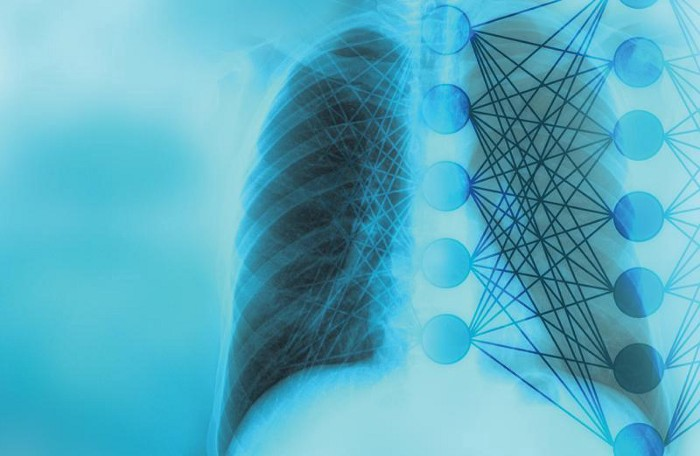

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Initial Imports

In [1]:
# Used to access the dataset on personal Google Drive
from google.colab import drive

# Used for data manipulation and visualization
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import class_weight
from matplotlib import pyplot as plt

# Used to preprocess data
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms as T, datasets, models

# Used to develop CNNs
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

# Used to calculate processing time per epoch
import time
import datetime

# Save history of model's training
import pickle

# Used for model evaluation
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Remove notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Get train, validation and test paths
PATH = "/content/drive/My Drive/Colab Notebooks/Practice/Datasets/X-ray/"

trainPath = os.path.join(PATH, "train")
valPath = os.path.join(PATH, "validation")
testPath = os.path.join(PATH, "test")

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) will allow us to understand the Pneumonia image dataset.

In [4]:
# Load images into numpy arrays
def load(path, imgSize):
    
    FOLDERS = ['PNEUMONIA', 'NORMAL']
    # Classification works good at image size 224 x 224
    SIZE = imgSize

    data = []

    # Go through every folder in dataset
    for folder in FOLDERS:
        fullPath = os.path.join(path, folder)

        # Get label for images in folder - 0 is for NORMAL and 1 is for PNEUMONIA
        num = FOLDERS.index(folder)

        # Go through every image in the folder
        for img in os.listdir(fullPath):
          # Get image's full path
          imgPath = os.path.join(fullPath, img)

          try:
            # Get data from image
            imgData = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
            # Resize image - not all images have the same size
            resized = cv2.resize(imgData, (SIZE, SIZE))
            # Add resized image and label of image - tuple
            data.append((resized, num))
          except Exception as e:
            print(e)

    return np.array(data)

In [5]:
# Load train, validation and test
train = load(trainPath, 150)
validation = load(valPath, 150)
test = load(testPath, 150)

### How is the data split between train, validation and test sets?

In order for us to explore the data, first we need to be aware how big every dataset is.

The downloaded dataset was split in the following way:
1. **train** - used to learn the parameters of the model.
2. **validate** - used to measure how accurately the model predicts data.
3. **test** - used as a proxy for unseen data and evaluate how the model is doing on the test set.

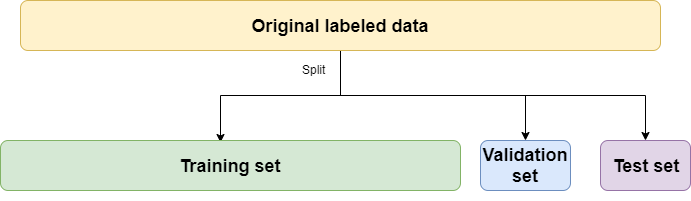

In [6]:
total = len(train) + len(validation) + len(test)

print(f"Training set:\t{len(train)} ({round((len(train) / total) * 100, 1)}%)\n")
print(f"Validation set:\t{len(validation)} ({round((len(validation) / total) * 100, 1)}%)\n")
print(f"Test set:\t{len(test)} ({round((len(test) / total) * 100, 1)}%)")

Training set:	5222 (89.1%)

Validation set:	16 (0.3%)

Test set:	624 (10.6%)


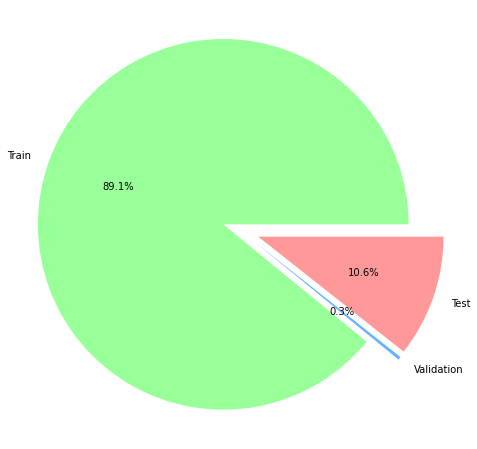

In [7]:
sizes = [len(train), len(validation), len(test)]
labels = ["Train", "Validation", "Test"]
explode = [0.1, 0.1, 0.1]
colors = ['#99ff99','#66b3ff','#ff9999']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%')
ax.axis("equal")
fig.set_size_inches(8,8)

plt.show()

The validation set is the smallest one and we will have to look into it.

### Are the datasets imbalanced?

If the datasets are imbalanced, we will have to further investigate and balance them, so the model can correctly classify patients with pneumonia from the healthy ones.

In [8]:
# Display the total target values of the data
def showTargets(data, title):
  plt.title(title)
  sns.countplot(data[:, 1])
  plt.show()

In [9]:
# Display the number of healthy lungs and lungs with pneumonia
def countTargets(data):
  counter = {
      0: 0,   # Patient does not have pneumonia
      1: 1    # Patient has pneumonia
  }
  for target in data[:, 1]:
    if target == 0:
      counter[0] += 1
    else:
      counter[1] += 1
  
  print(f"Healthy lungs:\t\t{counter[0]} ({round((counter[0] / (counter[0] + counter[1])) * 100, 2)}%)\n")
  print(f"Lungs with pneumonia:\t{counter[1]} ({round((counter[1] / (counter[0] + counter[1])) * 100, 2)}%)\n")

Healthy lungs:		3875 (74.19%)

Lungs with pneumonia:	1348 (25.81%)



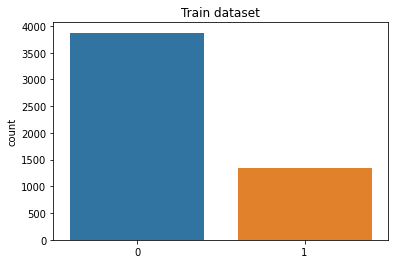

In [10]:
countTargets(train)
showTargets(train, "Train dataset")

Healthy lungs:		8 (47.06%)

Lungs with pneumonia:	9 (52.94%)



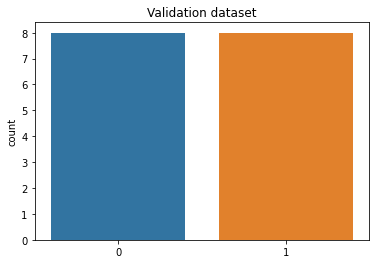

In [11]:
countTargets(validation)
showTargets(validation, "Validation dataset")

Healthy lungs:		390 (62.4%)

Lungs with pneumonia:	235 (37.6%)



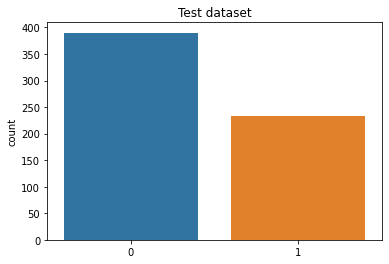

In [12]:
countTargets(test)
showTargets(test, "Test dataset")

The **train** and **test** datasets are imbalanced and we will have to further investigate this issue in order to produce accurate model results.

#### What are the initial class weights for the training dataset?
The training dataset is imbalanced and it will cause issues with predicting the minority class (images of patients with pneumonia). We will use the `class_weight.compute_class_weight` function from `sklearn` to calculate the current weights.

In [13]:
# Calculate the class weights for the training dataset
classWeights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train[:, 1]), y=train[:, 1])

print(f"Class 0 - does not pneumonia:\t{round(max(classWeights), 2)}\n")
print(f"Class 1 - has pneumonia:\t{round(min(classWeights), 2)}")

Class 0 - does not pneumonia:	1.94

Class 1 - has pneumonia:	0.67


### What do healthy lungs and pneumonial lungs look like?
In this section we will look at both **0** (does not have pneumonia) and **1** (has pneumonia) lungs from the training dataset in order to better understand the images.

In [14]:
# Display image with original colours
def showImg(img):
  title = ""

  if img[1] == 1:
    title = "Has pneumonia"
  else:
    title = "Does not have pneumonia"

  plt.figure(figsize=(6, 6))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
  plt.show()

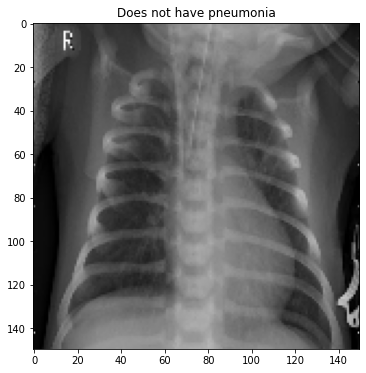

In [15]:
showImg(train[0])

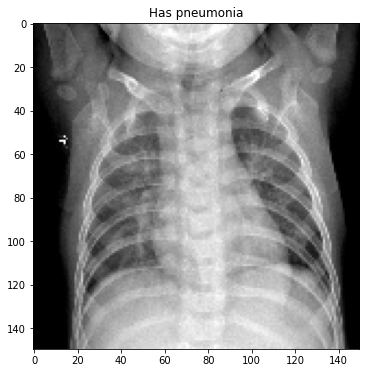

In [16]:
showImg(train[-1])

As mentioned in the [link](cell.com/cell/fulltext/S0092-8674(18)30154-5):

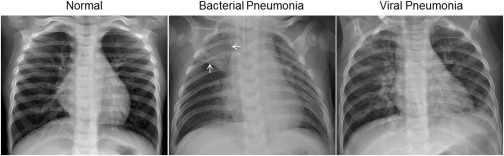

*The normal chest X-ray (left panel) depicts clear lungs without any areas of 
abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse “interstitial” pattern in both lungs.*

**NOTE**: At the moment the images are sorted the way they were iterated in the folders - first the normal images are shown and then the ones with pneumonia. We will shuffle the data to avoid the model overfitting.

### Global Thresholding

This is based on bimodal histogram (when two clearly separate groups are visible in a histogram, you have a bimodal distribution) - the object can be extracted from the background by a simple operation that compares image values with a threshold value *T*.

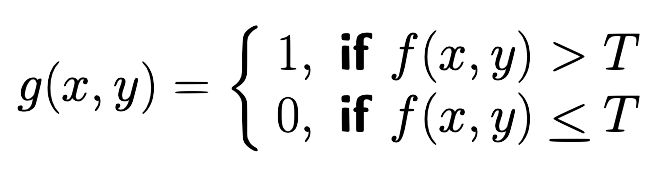

The result of thresholding is a binary image, where pixels with intensity value of **1** correspond to objects, whereas pixels with value **0** correspond to the background.

In [17]:
# Display images by using a basic threshold
def showThresholds(img):
  thresholds = [100, 140, 180]
  count = 1

  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
  
  for T in thresholds:
    # Plot on current column
    plt.subplot(1, len(thresholds),count)
    val, thresh = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap='gray')
    plt.title(f"Threshold = {T}")

    count += 1

  plt.show()

#### Pneumonia Thresholds
In this section we will look at **Global Tresholding** for patients with Pneumonia.

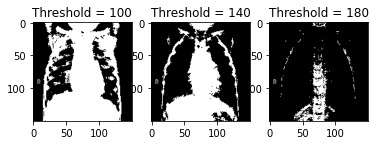

In [18]:
# Randomly selected image with Pneumonia
showThresholds(train[-22, 0])

#### Healthy Thresholds
In this section we will look at **Global Tresholding** for healthy patients.

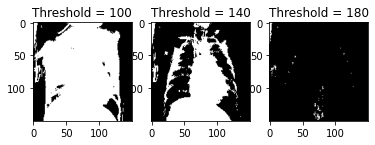

In [19]:
# Randomly selected healthy image
showThresholds(train[2, 0])

### K-means segmentation
K-means will group pixels similar pixels together. This will give us a more comprehensive understanding of the objects within the image.

In [20]:
# Perform KMeans segmendation on an image
def kMeansSegmentation(img, k_=2):
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  img_vect = np.float32(img).reshape(-1,3)
  criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
  ret, label, centroids = cv2.kmeans(img_vect, k_, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  centroids = np.uint8(centroids)
  imgKmeans = centroids[label.flatten()]
  return imgKmeans.reshape(img.shape)

#### Pneumonia KMeans
In this section we will look at **KMeans** for an image with Pneumonia.

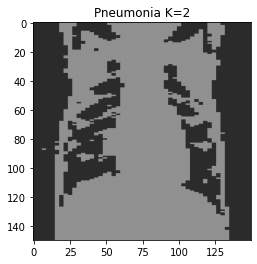

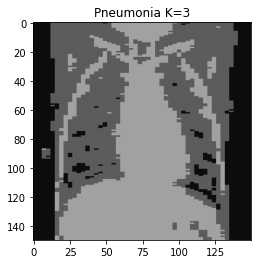

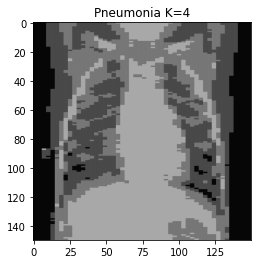

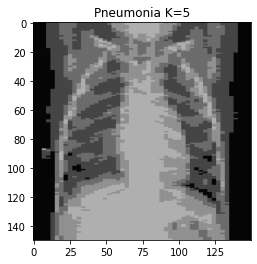

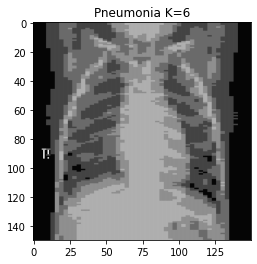

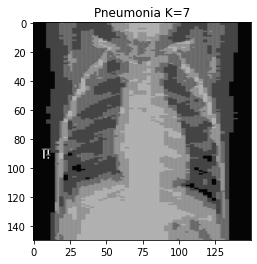

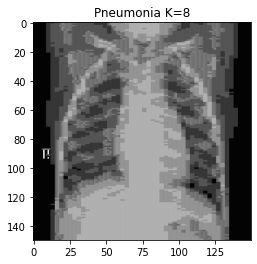

In [21]:
kValues = [2, 3, 4, 5, 6, 7, 8]

for k in kValues:
  # Perform Kmeans on image with Pneumonia with different K values
  plt.imshow(cv2.cvtColor(kMeansSegmentation(train[-22, 0], k), cv2.COLOR_BGR2RGB))
  plt.title(f"Pneumonia K={k}")
  plt.show()

#### Healthy KMeans
In this section we will look at **KMeans** for a healthy image.

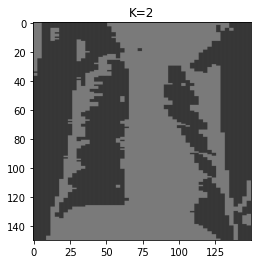

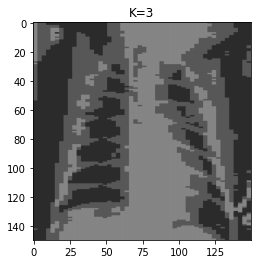

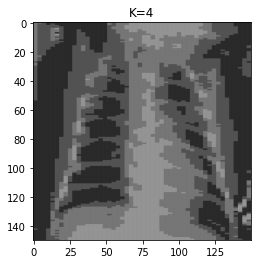

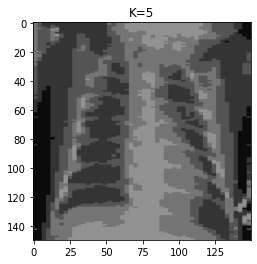

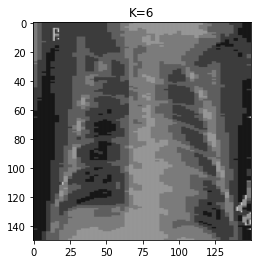

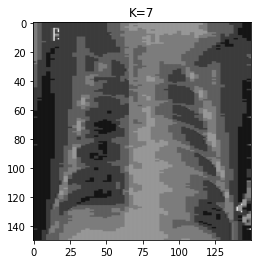

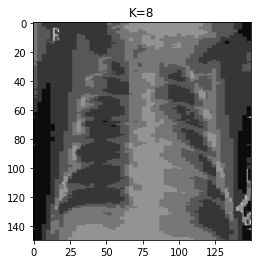

In [22]:
kValues = [2, 3, 4, 5, 6, 7, 8]

for k in kValues:
  # Perform Kmeans on healthy image with different K values
  plt.imshow(cv2.cvtColor(kMeansSegmentation(train[0, 0], k), cv2.COLOR_BGR2RGB))
  plt.title(f"K={k}")
  plt.show()

## Model


So far we have explored the dataset and prepared the data to be fed into a model. In this section we will develop a model to classify healthy patients (**0**) and patients with pneumonia (**1**).

Fully Connected Networks are effective for classification and regression tasks, however in image classification the network does not scale well for large images. For example, a small image with a size of 200 x 200 pixels with 3 layers (red, green and blue) would require 120,00 weights ($200 * 200 * 3$). This would require too much computation and can very easily overfit. 

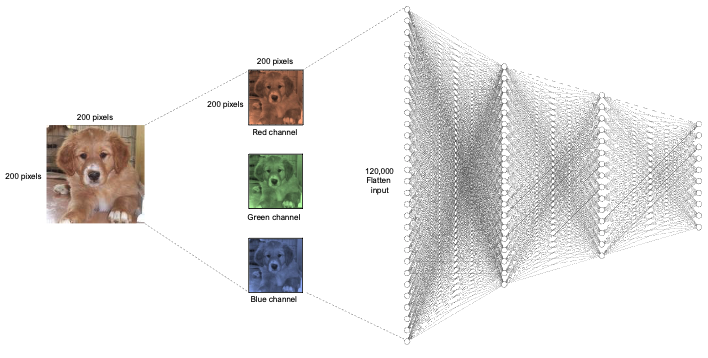

Convolution Neural Networks (CNN or ConvNet for short) are one of the various types of Deep Learning Neural Networks. It is used for image classification, iamge recognition, object detection, object segmentation etc. There are three main type of layers:
- **Convolutional Layer** - extracts features by combining an input tensor and a filter (known as **kernel**) to produce a feature map (**output**) through the convolution operation. in order to calculate the output of the Convolution the following formula is used:</br></br>\begin{align}\frac{W - K + 2P}{2} + 1\end{align}</br>

 - **W** - input size
 - **K** - kernel size
 - **P** - padding (added pixels with value of 0 which are added when the image is being processed by the **kernel**)
 - **S** - stride (how many cells the **kernel** should move  to perform the next calculations)
</br>
- **Pooling Layer** - is a downsampling technique which reduces the size of representation of the image and speeds up calculations by either extracting the average or maximum value from a given **kernel** size. In order to calculate the output of the Pooling operation the following formula is used: </br></br>\begin{align}\frac{W - K}{2} + 1\end{align}</br>
 - **Average** - calculate the average value in the feature map
 - **Maximum** - calculate the maximum value for each patch of the feature map
 </br>
- **Fully-Connected Layer** - operates on a flattened input where every input is connected to all neurons. This type of layers are used at the end of ConvNet architectures and can also be used to optimize objectives. In this case our objective is binary classification.

### GPU Connection
Firstly, let's check if there is an available GPU to speed up the CNN's computation. When creating tensors and models are initialized on the CPU. Let's define a `device` which will store if we can process the data on a CPU or a GPU.



In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using {device.type} for processing.")

Currently using cuda for processing.


### Data Preparation
In this section we will address the latter mentioned issues and we will prepare the data for the model in order for it to be trained.

We will transform the images the following way:

1. Load the images by using `ImageFolder`
 - Resize the image with the given size in `imgSize` which is 224 - this is to speed up computation and make all of the images the same size.
 - Convert the images to tensors (`ToTensor`) - In order to speed up the model's performance and use a GPU, we will transform the data Pytorch Tensors. This was not done earlier in order to explore the images easier.
 - Normalize the numbers of the images - rmalizes the pixels of the image to range from 0 to 1. Pixel values can range between 0 and 256. Every number represents a different colour. When passing images through a deep neural network, the computation of high numeric values can become even more complex.

2. We will use `DataLoader` to:
 - Split the data into batches. Batches split the data into a series of smaller data chunks which are handed to the model one at a time. After every passed batch the model does backpropagation and makes changes to its weights and biases. A batch of the power of 2 gives a better performance. Typical power of 2 batch sizes range from 32 to 256, with 16 sometimes being attempted for large models. 
 - Shuffle the data. At the moment the data is not shuffled and the model is likely to overfit.

In [24]:
def preprocess(path, batch, imgSize):
  transform = T.Compose([
                         # Resize image to given size
                         T.Resize([imgSize, imgSize]),
                         # Convert to Tensor
                         T.ToTensor(),
                         # Normalize image
                         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  data = datasets.ImageFolder(path, transform=transform)

  dataLoader = torch.utils.data.DataLoader(data, batch_size = batch, shuffle = True)
  return dataLoader

In [25]:
# These variables are used in the 'run' function
BATCH = 64
EPOCHS = 20
lr = 0.01

In [26]:
IMG_SIZE = 224

# Split the data into batches with given image size
trainData = preprocess(trainPath, BATCH, IMG_SIZE)

# Make the validation and test data into 1 batch with given image size
validationData = preprocess(valPath, validation.shape[0], IMG_SIZE)
testData = preprocess(testPath, test.shape[0], IMG_SIZE)

### Metrics and loss

The metric that we will use to evaluate our models will be **F1 score**. It measures the model's accuracy on a dataset. It is usually used to evaluate binary classification systems into positives (healthy patients) and negatives (patients with pneumonia). The **F-score** combines both precision and recall of the model and it is the [harmonic mean](https://deepai.org/machine-learning-glossary-and-terms/f-score#:~:text=The%20F%2Dscore%2C%20also%20called,positive'%20or%20'negative'.) of precision and recall. </br></br>

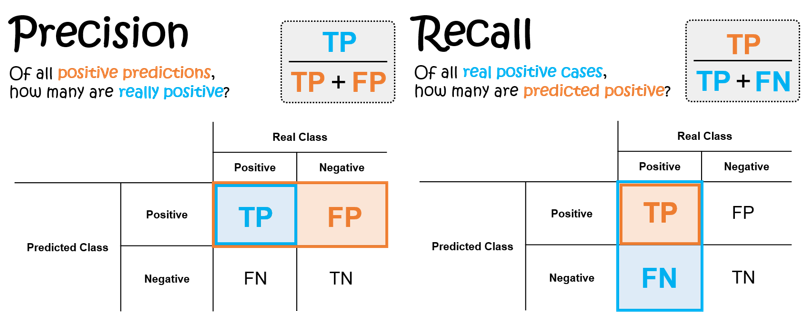
</br></br>
\begin{align}
  F1\,score = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{align}

In [41]:
def getMetrics(model, data, device):
  # Evaluation mode
  model.eval()
  
  # Disable gradients
  with torch.no_grad():
    for images, yTrue in data:
      # Convert tensors to GPU / CPU
      images = images.to(device)
      yTrue = yTrue.to(device)

      # Get model's predictions
      yHat = model(images)

      # Convert results from CUDA to CPU numpy arrays
      yTrue = yTrue.cpu().detach().numpy()
      yHat = yHat.cpu().detach().numpy()
      # Convert predictions to integers
      yHat = yHat.astype(np.int)

      # F1 score
      print(f"F1 score: {round(f1_score(yTrue, yHat) * 100, 2)}%\n")
      print(f"Accuracy: {round(accuracy_score(yTrue, yHat) * 100, 2)}%\n")

      tn, fp, fn, tp = confusion_matrix(yTrue, yHat).ravel()
      
      # Display confusion matrix
      print("True Positives (TP): {0:03d}\t\t\tFalse Positives (FP): {0:03d}\n" .format(tp, fp))
      print("True Negatives (TN): {0:03d}\t\t\tFalse Negatives (FN): {0:03d}" .format(tn, fn))

      # Validation and test data have 1 batch from all examples
      break

Let's make a function that will showcase the loss per epoch. It will be used in the next section - **Train** (in the `train` function).

In [28]:
# Display the Loss per epoch
def showLoss(history):
  # Make plot's title bigger
  plt.rc('axes', titlesize=20)

  # Resize plot
  plt.figure(figsize=(10, 7))
  plt.title("Loss per iteration")
  # Show dots per iteration
  plt.scatter(history['epochs'], history['loss'], c="r")
  # Show line 
  plt.plot(history['epochs'], history['loss'])
  # Set axis labels
  plt.xlabel("Epochs", size=20)
  plt.ylabel("Loss", size=20)
  # Display plot
  plt.show()

### Train
In this function we will construct the `train` function which will train the network.

#### Loss function
As it was found in the **Exploratory Data Analysis** section, the dataset is imbalanced - there are more healthy patients (**0**) than patients with pneumonia (**1**). We will use **Focal Loss** as our loss function. However in order to understand **Focal Loss** we need to look into **Cross-Entropy** first.

**Cross-Entropy**

This loss (also known as log loss) measures the performance of a classification model whose output is the a probability value between 0 and 1. The loss increases as the predicted probability seperates from the true label.
<br><br>

\begin{align}
−(𝑦log(𝑝)+(1−𝑦)log(1−𝑝))
\end{align}

<br>

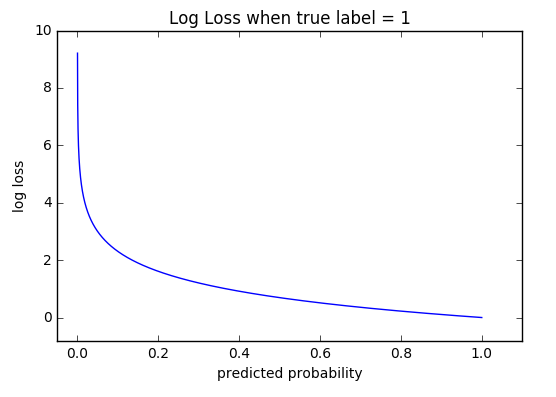

**Focal Loss**

This loss is an improvement of **Cross-Entropy** which handles the class imbalance problem through assigning more weights to hard or easily misclassified examples by using γ to smoothly adjust the rate at which easy examples are down-weighted. Focal loss reduces the loss contribution from easy examples and increases the importance of correcting misclassified examples.
<br><br>
\begin{align}
−a(1-p)^γ  log(p)
\end{align}
<br>
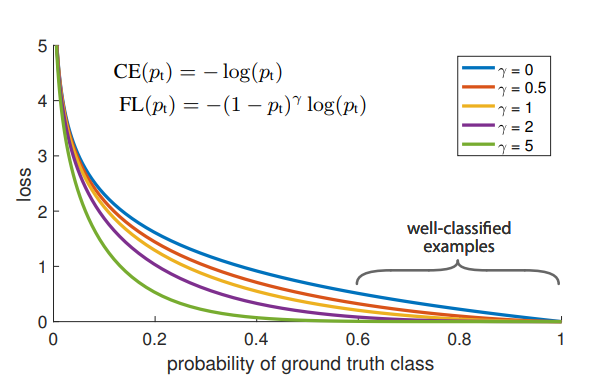

In [29]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs.squeeze(),  targets.float())
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

#### Optimizer

We will use the Adam optimizer. It is one of the most popular optimizers - a combination of the best properties from: 
- **AdaGrad** -  maintains a per-parameter learning rate that improves performance on problems with sparse gradients 

- **RMSProp** - maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing), meaning that the algorithm does well on online and non-stationary problems (e.g. noisy).

#### Train function
In this section we will create the training function which will train the model and return a dictionary (`history`) with the loss (per epoch) and the epochs, so they can be passed on the `showLoss` function.

In [30]:
def trainModel(model, train, epochs, lr, device, path):
  loss = FocalLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.train()

  # Store the model's performance
  history = {
    "loss": [],
    "epochs": []
  }
  

  # Go over the training data for 'epochs' times
  for epoch in range(epochs):
    # Get the current time (when starting an epoch)
    start = time.time()

    # Store the loss per batch
    epochLoss = []

    # Loop through every batch in the training data
    for images, yTrue in train:
      # Convert tensors to GPU / CPU
      images = images.to(device)

      yTrue = yTrue.type(torch.FloatTensor)
      yTrue = yTrue.to(device)
      # 1. Make gradients 0
      optimizer.zero_grad()
      # 2. Get model's predictions
      yHat = model(images)
      # 3. Get the loss (FocalLoss)
      l = loss(yHat, yTrue)
      # 4. Calculate derivatives
      l.backward()
      # 5. Update the model's weights
      optimizer.step()

      # Store current batch loss
      epochLoss.append(l.item())
      
      #  -------------------------------------
      # |               TEST!                 |
      #  -------------------------------------
      # break

    # Get average loss for one epoch
    lossAvg = sum(epochLoss) / len(epochLoss)
    # Get time per epoch
    epochTime = str(datetime.timedelta(seconds=int(time.time() - start)))
    print(f"Time per epoch: {epochTime}\t\tEpoch: {epoch + 1}\tLoss: {round(lossAvg, 2)}\n")

    # Store information for the current epoch
    history['loss'].append(lossAvg)
    history['epochs'].append(epoch + 1)

    #  -------------------------------------
    # |               TEST!                 |
    #  -------------------------------------
    # break

  print("\n")

  # Show the loss per epoch
  showLoss(history)

  # Append model folder to path
  modelPath = os.path.join(path, "X-ray Model")

  # Create path if it does not exist
  if not os.path.exists(modelPath):
    os.makedirs(modelPath)

  # Create model's name
  modelPath = os.path.join(modelPath, "model.pth")
  # Save model to drive
  torch.save(model, modelPath)

  # Save history dictionary

  # Create file path
  hPath = os.path.join(path, "X-ray Model")
  hPath = os.path.join(hPath, 'loss.pickle')
  # Save data
  with open(hPath, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

  # Return trained model
  return model

In [31]:
# Check if the model needs to be trained or not
def run(model, train, lr, epochs, device, path):
  # Trained model's weights and history folder
  path = os.path.join(path, "X-ray Model")
  # Training history's file
  hPath = os.path.join(path, 'loss.pickle')
  # Trained model's weights
  modelPath = os.path.join(path, "model.pth")
  print(modelPath)
  # Model exists
  if(os.path.exists(modelPath)):

    # History exists
    if(os.path.exists(hPath)):
      # Load history
      with open(hPath, 'rb') as handle:
        history = pickle.load(handle)
        showLoss(history)
    else:
      print(f"Model's history (loss per epoch) was not found...")
    # Load model
    model = torch.load(modelPath)

    print("Model successfully!")

  # Model does not exist
  else:
    print("No pretrained model found. Starting training!")
    # Train model
    # model = trainModel(model, train, epochs, lr, device, path)

  return model

### NickNet based on AlexNet


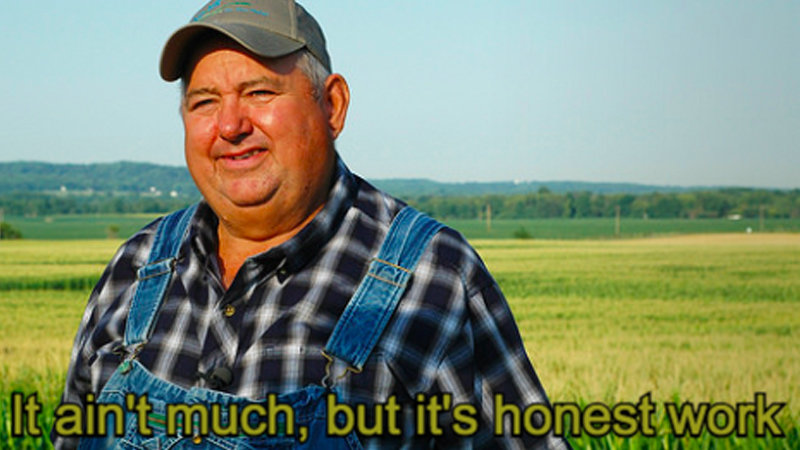

The model that we will try on the pneumonia dataset is based on **AlexNet**. 
It was designed by **Alex Krizhevsky** and achieved top-1 and top-5 error rates in the **ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2010**. 

AlexNet was the first deep convolutional neural network that could run on GPU hardware. Due to memory restrictions the training of the network was parallelized on two GPUs, meaning that one GPU processed only half of the model. In modern GPUs splitting an AlexNet is not required due to rapidly increased GPU speeds.


The design is simiar to **LeNet** but **AlexNet** is deeper and with more filters per layer. 

alexnet-all.svg

The good performance of AlexNet is based on:

1. **Overlapping Max Pooling** - the pooling windows overlap so spatial information is not lost and the model does not overfit easily.

2. **Dropout** - this was introduced to reduce model's overfitting by turning the weights to some nodes (randomly) to 0 in order to prevent the model from overfitting. This proved also enhanced computer vision model's performance.

3. **ReLU** - instead of using sigmoid activation function, AlexNet used ReLU which makes the training easier when using different parameter initializations. ReLU also helps with calculating the gradients by making the numbers positive, whereas sigmoid gradients are either closer to 0 or 1 which stops backpropagation from updating some of the model parameters. If the model’s parameters are not correctly initialized the sigmoid function could return gradients close to 0 which does not make training effective. In addition, convolution and matrix multiplications were also parallelized in the hardware to speed up the model’s training.

The proposed model has the following AlexNet modifications:
1. The output channel sizes have been decreased and the fully connected layers (`nn.Linear`) sizes have been drecreased because we have less amount of data compared to the dataset AlexNet was trained on.

2. We use Focal Loss because the dataset is unbalanced. For more information please read the *Metrics and loss* chapter in this notebook.

3. The dataset is imbalanced and this can cause the **accuracy paradox** - the accuracy will be 99% accurate because there are significantly more healthy patients than patients with pneumonia. We will use **F1 score** but we will also display the accuracy to see if the **accuracy paradox** occurs.

4. The output features of the last `nn.Linear` layer will be 1 because we have 2 classes - 0 (healthy patients) and 1 (patients with pneumonia).

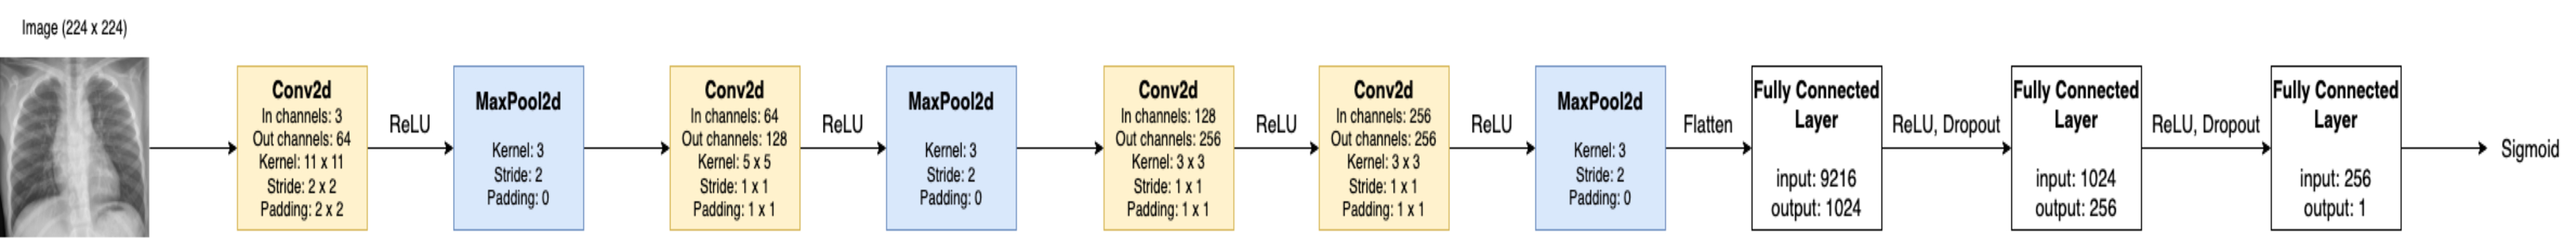

In [32]:
class NickNet(nn.Module):
  def __init__(self):
    super(NickNet, self).__init__()
    # Define Alex Net architecture
    self.model = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), 
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
      
      nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),

      nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
      nn.ReLU(inplace=True),

      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
      nn.ReLU(inplace=True),

      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.ReLU(inplace=True),

      nn.Flatten(),

      nn.Linear(in_features= 9216, out_features= 1024),
      nn.ReLU(inplace=True),
      nn.Dropout(p = 0.5),

      nn.Linear(in_features= 1024, out_features= 256),
      nn.ReLU(inplace=True),
      nn.Dropout(p = 0.5),

      # out_features = 2 because we have 2 classes
      nn.Linear(in_features=256 , out_features=1),
      
      nn.Sigmoid()
    )
  
  def forward(self, x):
    # Generate model's predictions
    predictions = self.model(x)
    # Reshape predictions to 1D array to match the yTrue values
    predictions = predictions.view(predictions.shape[0])
    # predictions= predictions.type(torch.LongTensor)
    return predictions

In [33]:
model = NickNet()

# Convert tensors to GPU / CPU
model = model.to(device)

/content/drive/My Drive/Colab Notebooks/Practice/Datasets/X-ray/X-ray Model/model.pth


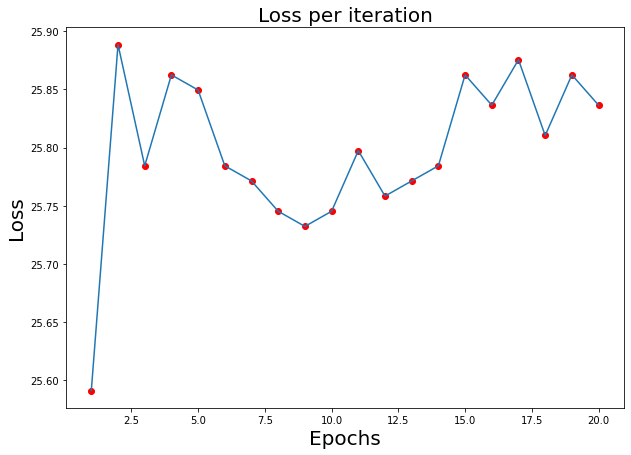

Model successfully!


In [34]:
"""
If pretrained weights and loss files are found - load them
If pretrained weights are not found - train model
"""
model = run(model, trainData, lr, EPOCHS, device, PATH)

In [42]:
# Show F1 score and confusion matrix
getMetrics(model, validationData, device)

F1 score: 66.67%

Accuracy: 50.0%

True Positives (TP): 008			False Positives (FP): 008

True Negatives (TN): 000			False Negatives (FN): 000


In [43]:
# Show F1 score and confusion matrix
getMetrics(model, testData, device)

F1 score: 76.92%

Accuracy: 62.5%

True Positives (TP): 390			False Positives (FP): 390

True Negatives (TN): 000			False Negatives (FN): 000


## Conclusion

Overall we do an **Exploratory Data Analysis** to get a better understanding of the dataset. Afterwards we prerprocess the data so it can be given to the model and finally we design a model based on the AlexNet architecture. The proposed model has a stuck loss and it cannot learn to classify images correctly. However the validation data is not enough to determine the model's performance. because there are 16 examples.

In order to further improve the model's the following research can be made:
1. Investigate the loss function. In this scenario we use the **Focal Loss** to deal with the imbalanced classes. However other losses can be used to see if that improves the model's performance.
2. Investigate the model itself. The proposed **CNN** is based on AlexNet but further improvements could be made on the convolutions and poolings.
3. Investigate the learning rate and epochs. Maybe the learning rate is too big or too small and more iterations over the datasets might be required.
